In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt 
from vanilla_nn_class import VanillaNN

%matplotlib inline  
%config InlineBackend.figure_format = 'retina'

### Loading the Data


In [2]:
data_path = 'dataset/hour.csv'
ride_data = pd.read_csv(data_path)
ride_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


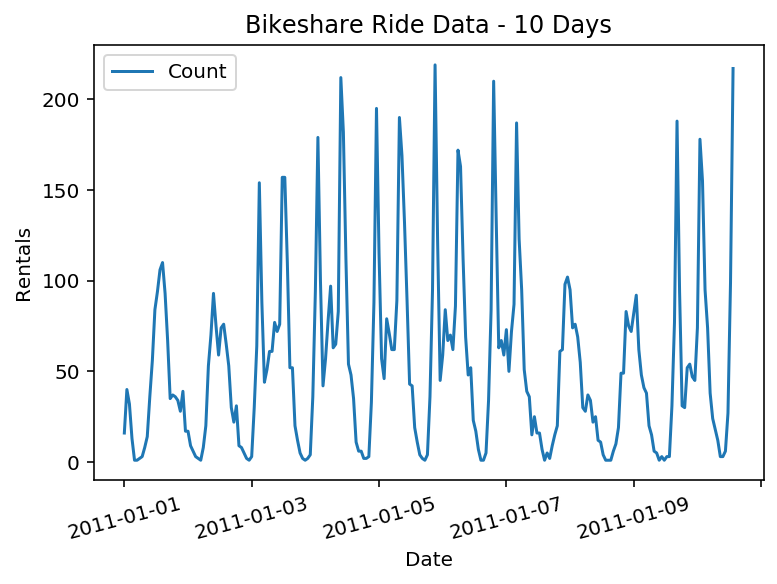

In [3]:
days = 24*10
ride_data[:days].plot(x='dteday', y='cnt', label='Count')
plt.title(label='Bikeshare Ride Data - 10 Days')
plt.ylabel('Rentals')
plt.xlabel('Date')
plt.xticks(rotation = 15)
plt.show()

## Dummy Variables  

In [4]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']

for field in dummy_fields:
    dummies = pd.get_dummies(ride_data[field], prefix=field, drop_first=False)
    ride_data = pd.concat([ride_data, dummies], axis=1)

fields_to_drop = ['dteday', 'instant', 'season', 'weathersit', 'weekday', 'atemp', 'workingday']
data = ride_data.drop(fields_to_drop, axis=1)
data.head()


,yr,mnth,hr,holiday,temp,hum,windspeed,casual,registered,cnt,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,1,0,0,0.24,0.81,0.0,3,13,16,...,0,0,0,0,0,0,0,0,0,1
1,0,1,1,0,0.22,0.80,0.0,8,32,40,...,0,0,0,0,0,0,0,0,0,1
2,0,1,2,0,0.22,0.80,0.0,5,27,32,...,0,0,0,0,0,0,0,0,0,1
3,0,1,3,0,0.24,0.75,0.0,3,10,13,...,0,0,0,0,0,0,0,0,0,1
4,0,1,4,0,0.24,0.75,0.0,0,1,1,...,0,0,0,0,0,0,0,0,0,1


## Scaling Data

In [5]:
cont_fields = ['temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']
scaled_features = {} # create empty dictionary
for field in cont_fields:
    mean = data[field].mean()
    std = data[field].std()
    scaled_features[field] = [mean, std] # store for later to unormalize data
    data.loc[:,field] = (data[field] - mean) / std # normalize data

data.head()

,yr,mnth,hr,holiday,temp,hum,windspeed,casual,registered,cnt,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,1,0,0,-1.334609,0.947345,-1.553844,-0.662736,-0.930162,-0.956312,...,0,0,0,0,0,0,0,0,0,1
1,0,1,1,0,-1.438475,0.895513,-1.553844,-0.561326,-0.804632,-0.823998,...,0,0,0,0,0,0,0,0,0,1
2,0,1,2,0,-1.438475,0.895513,-1.553844,-0.622172,-0.837666,-0.868103,...,0,0,0,0,0,0,0,0,0,1
3,0,1,3,0,-1.334609,0.636351,-1.553844,-0.662736,-0.949983,-0.972851,...,0,0,0,0,0,0,0,0,0,1
4,0,1,4,0,-1.334609,0.636351,-1.553844,-0.723582,-1.009445,-1.039008,...,0,0,0,0,0,0,0,0,0,1


## Test, Train, Validation Data


In [6]:
# data from last 30 days
data = data[:-30*24]

# targets (X)
target_fields = ['cnt', 'casual', 'registered'] 
targets = data[target_fields]

# features (y)
features = data.drop(target_fields, axis=1)

# test data
test_data = data[-30*24:]
# test features
test_features = test_data.drop(target_fields, axis=1)
# test targets
test_targets = test_data[target_fields]


In [7]:
# training and vaildation data
train_features = features[:-40*24]
train_targets = targets[:-40*24]
valid_features = features[-40*24:]
valid_targets = targets[-40*24:]

In [8]:
print('Train Features - {} <---> Train Targets - {}'.format(train_features.shape, train_targets.shape))

Train Features - (15699, 58) <---> Train Targets - (15699, 3)


In [9]:
def MSE(y, Y):
    return np.mean((y - Y)**2)

In [18]:
# iterations = 10
learning_rate = 1.28
hidden_nodes = 10
output_nodes = 1
epochs = 1500

# print(train_features.shape)
model = VanillaNN(train_features.shape[1], hidden_nodes, output_nodes, learning_rate)
losses = {'train': [], 'validation': []}
for e in range(epochs):
    batch = np.random.choice(train_features.index, size=128)
    features = train_features.iloc[batch].values # features
    targets = train_targets.iloc[batch]['cnt'] # targets

    model.train(features, targets)
    # cacluculate loss
    train_loss = MSE(model.forward(train_features).T, train_targets['cnt'].values)    
    valid_loss = MSE(model.forward(valid_features).T, valid_targets['cnt'].values)
    losses['train'].append(train_loss)
    losses['validation'].append(valid_loss)
    # print
    if e % 100 == 0:
        print('Epoch {}/{} -- Train Loss: {:.3f}% -- Validation Loss: {:.3f}%'.format(e+1, epochs, 
                                                                                      train_loss, valid_loss))

Epoch 1/1500 -- Train Loss: 6.309% -- Validation Loss: 6.999%
Epoch 101/1500 -- Train Loss: 0.800% -- Validation Loss: 1.054%
Epoch 201/1500 -- Train Loss: 0.781% -- Validation Loss: 1.078%
Epoch 301/1500 -- Train Loss: 0.762% -- Validation Loss: 1.064%
Epoch 401/1500 -- Train Loss: 0.754% -- Validation Loss: 1.056%
Epoch 501/1500 -- Train Loss: 0.756% -- Validation Loss: 1.056%
Epoch 601/1500 -- Train Loss: 0.750% -- Validation Loss: 1.060%
Epoch 701/1500 -- Train Loss: 0.744% -- Validation Loss: 1.053%
Epoch 801/1500 -- Train Loss: 0.767% -- Validation Loss: 1.067%
Epoch 901/1500 -- Train Loss: 0.740% -- Validation Loss: 1.041%
Epoch 1001/1500 -- Train Loss: 0.745% -- Validation Loss: 1.042%
Epoch 1101/1500 -- Train Loss: 0.737% -- Validation Loss: 1.042%
Epoch 1201/1500 -- Train Loss: 0.736% -- Validation Loss: 1.036%
Epoch 1301/1500 -- Train Loss: 0.740% -- Validation Loss: 1.054%
Epoch 1401/1500 -- Train Loss: 0.643% -- Validation Loss: 0.838%


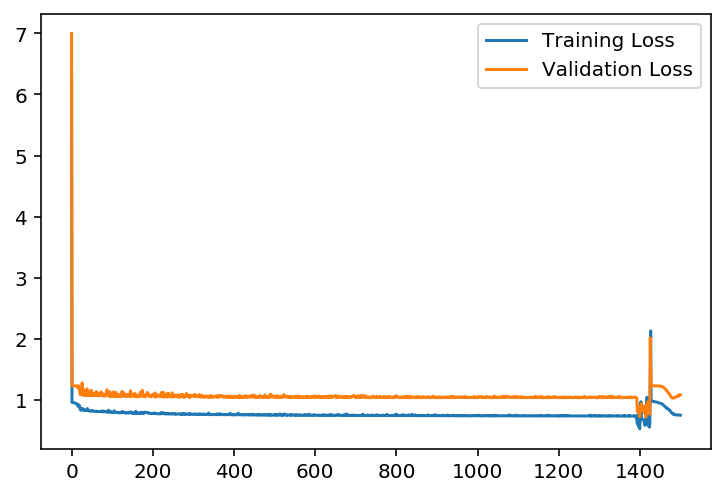

In [19]:
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['validation'], label='Validation Loss')
plt.legend()
_ = plt.ylim()


